<a href="https://colab.research.google.com/github/karino2/tegashiki/blob/master/tegashiki_symbol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tegashiki**

In [0]:
import os
import datetime
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import preprocessing


In [0]:
from google.colab import auth
auth.authenticate_user()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
def get_if_necessary(fname):
  if os.path.exists(fname):
    return
  !gsutil cp gs://karino2-tegashiki/dataset/{fname} {fname}

def get_and_load(fname):
  get_if_necessary(fname)
  with gzip.open(fname,'rb') as f:
    return pickle.load(f)  
  
def send_file(fname):
  !gsutil cp {fname} gs://karino2-tegashiki/dataset/
    
def dump_and_send(obj, fname):
  with gzip.open(fname,'wb') as f:
    pickle.dump(obj, f)
  send_file(fname)


In [0]:
BEGIN_OF_SEQ = 112
END_OF_SEQ=0

# MAX_TEX_LEN=206+2
# +2 is bos, eos
# MAX_TRAIN_LEN=88+2

VOCAB_SIZE=113

# MAX_STROKE_SEQ_LEN=1948
MAX_STROKE_SEQ_LEN=343

# MAX_VALID_LEN=206+2
# MAX_VALID_STROKE_LEN=6620
# MAX_VALID_STROKE_LEN=1154
MAX_VALID_STROKE_LEN=207

NORMALIZE_MAX=2000

INPUT_TYPE_POINT=1
INPUT_TYPE_SEP=2
INPUT_TYPE_END=0

# (x, y, TYPE)
INPUT_TYPE_DIM=3

### Model

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, RepeatVector, Reshape, Concatenate
from tensorflow.keras.layers import TimeDistributed, Flatten, Lambda, Add, Activation, Masking, Embedding
from tensorflow.keras.layers import AveragePooling1D, Conv1D, MaxPooling1D, SpatialDropout1D
from tensorflow.keras import regularizers
import  tensorflow.keras.layers as layers
# from tensorflow.keras.layers.embeddings import Embedding
import tensorflow.keras.backend as K

In [0]:
# DROPOUT_RATE=0.5
# L2_REGULARIZATION_RATE=0.1

DROPOUT_RATE=0.9
L2_REGULARIZATION_RATE=0.1


# large, 
GRU_HIDDEN=256

# model_small
# GRU_HIDDEN=128



 https://arxiv.org/abs/1803.01271

try to cover 500 len. and attention will handle larger case.
As paper noted, best kernel size depend on task.
I start from k=8 because our task is somewhat similar to P-MNIST, and k=8 is best for that task.

In [0]:
# TCN residual block in paper
# filter_size must be the same as out_channels?

# filter_size=32
# filter_size=25
def TCNResBlock(input, layer_depth, filter_size=10, kernel_size=8, dropout_rate=0.2):
  d = 2**layer_depth
  def conv(x):
    if L2_REGULARIZATION_RATE == 0.0:
      return Conv1D(filter_size, kernel_size, activation='relu', dilation_rate=d, padding='causal')(x)
    else:
      return Conv1D(filter_size, kernel_size, activation='relu', dilation_rate=d, padding='causal', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(x)
    
  x = conv(input)
  
  # https://github.com/ychfan/tf_estimator_barebone/blob/master/common/layers.py
  # weight norm implementation. But I use layer_norm for first trial.
  x = tf.contrib.layers.layer_norm(x)
  x = SpatialDropout1D(dropout_rate)(x)

  x = conv(x)
  x = tf.contrib.layers.layer_norm(x)
  x = SpatialDropout1D(dropout_rate)(x)
  
  res_input = input
  if filter_size != 3:
    # 1 by 1 conv to match inupt dim.
    res_input = Conv1D(filter_size, 1, padding='same')(input)
  res_input = res_input
  return tf.nn.relu(x + res_input)

def TCN(input, depth=8):
  x = input
  for i in range(depth):
    x = TCNResBlock(x, i, dropout_rate=DROPOUT_RATE)
  return x


In [0]:
def crnn_base(input_stroke_t):
  conved = Conv1D(32, 7, activation='relu', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(input_stroke_t)
  last = GRU(GRU_HIDDEN, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), recurrent_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(conved)
  return last

def tcn_base(input_stroke_t):
  tcn = TCN(input_stroke_t, 5)
  last = tcn[:, -1, :]
  return last

In [0]:
def create_model(input_stroke_t):
  # last = crnn_base(input_stroke_t)
  last = tcn_base(input_stroke_t)

  if L2_REGULARIZATION_RATE == 0.0:
    logit = Dense(VOCAB_SIZE)(last)
  else:
    logit = Dense(VOCAB_SIZE, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(last)
 
  return logit


## TPUEstimator

In [0]:
from tqdm.autonotebook import tqdm as tqdmn

In [0]:
DATA_DIR="gs://karino2-tegashiki/dataset"
TF_RECORD_FILE="{}/crohme2019_sym_rdp_longonly.tfrecord.gz".format(DATA_DIR)
TF_VALID_RECORD_FILE="{}/crohme2019_sym_rdp_longonly_valid.tfrecord.gz".format(DATA_DIR)

In [0]:
# MODEL_DIR="gs://karino2-tegashiki/sym_models/rnn_small_dropout05"
# MODEL_DIR="gs://karino2-tegashiki/sym_models/tcn_large_nonreg"
# MODEL_DIR="gs://karino2-tegashiki/sym_models/tcn_large_nonreg_filter25"
# MODEL_DIR="gs://karino2-tegashiki/sym_models/tcn_large_nonreg_filter25_fix"
# MODEL_DIR="gs://karino2-tegashiki/sym_models/tcn_large_dropout05"

# MODEL_DIR="gs://karino2-tegashiki/sym_models/rnn_large_nonreg"
# MODEL_DIR="gs://karino2-tegashiki/sym_models/tcn_filter25_dropout09"
# MODEL_DIR="gs://karino2-tegashiki/sym_models/tcn_filter25_dropout09_datanormalize"
# MODEL_DIR="gs://karino2-tegashiki/sym_models/tcn_pad_valid"
MODEL_DIR="gs://karino2-tegashiki/sym_models/tcn_filter10"


In [0]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.64.255.122:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 10745679936324090216),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3432856658049614464),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7391800042715554345),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3837759836338311585),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4845972270272118732),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 7178220457579273223),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 3878759788567036533),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 1955027729425271612),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 86878161737802

In [0]:
VALID_SAMPLE_NUM=10019 # len(valid_sym_labels)
TRAIN_STEP_PER_ONCE=1000
EVAL_BATCH_SIZE=8

In [0]:
def parser(serialized_example, maxstrokelen):
  features = tf.parse_single_example(
      serialized_example,
      features={
      'input_x': tf.FixedLenFeature([maxstrokelen], tf.int64),
      'input_y': tf.FixedLenFeature([maxstrokelen], tf.int64),
      'input_type': tf.FixedLenFeature([maxstrokelen], tf.int64),
      'label':tf.FixedLenFeature([], tf.int64)
      })
  
  input_x = tf.cast(features['input_x'], tf.int32)
  input_y = tf.cast(features['input_y'], tf.int32)
  input_type = tf.cast(features['input_type'], tf.int32)
  one_sample_stroke = tf.stack([input_x, input_y, input_type], 1)
  labels = tf.cast(features["label"], tf.int32)
  
  return {"stroke": one_sample_stroke}, labels

def parser_train(serialized_example):
  return parser(serialized_example, MAX_STROKE_SEQ_LEN)

def parser_valid(serialized_example):
  return parser(serialized_example, MAX_VALID_STROKE_LEN)

In [0]:

def tpu_input_fn(params):
  dataset = tf.data.TFRecordDataset(TF_RECORD_FILE, "GZIP")
  dataset = dataset.map(parser_train)
  dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.batch(params['batch_size'], drop_remainder=True)
  return dataset

def tpu_input_fn_valid(params):
  dataset = tf.data.TFRecordDataset(TF_VALID_RECORD_FILE, "GZIP")
  dataset = dataset.map(parser_valid)
  dataset = dataset.padded_batch(params['batch_size'],({'stroke': [MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM]}, []), drop_remainder=True)
  return dataset



In [0]:

def metric_fn(labels, predicted_classes):
    """Function to return metrics for evaluation."""
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   name="acc_op")
      
    return {"accuracy": accuracy}

def extract_params(features, mode, params):  
  input_stroke = tf.feature_column.input_layer(features, params['input_stroke'])

  input_stroke = tf.reshape(input_stroke, shape=(-1, MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM))
  return input_stroke

def extract_params_always_train(features, mode, params):
  return extract_params(features, tf.estimator.ModeKeys.TRAIN, params)
  
def tpu_model_fn(features, labels, mode, params):
  input_stroke = extract_params(features, mode, params)
  # input_stroke, input_for_dec, maxtklen = extract_params_always_train(features, mode, params)
  
  logit = create_model(input_stroke)
  
  predicted_classes = tf.math.argmax(logit,axis=1)
  
  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        "class_ids": predicted_classes[:, tf.newaxis],
        "logits": logit,
    }
    return tf.contrib.tpu.TPUEstimatorSpec(mode, predictions=predictions)  
  
  loss = tf.losses.sparse_softmax_cross_entropy(labels, logit)

  if mode == tf.estimator.ModeKeys.EVAL:
    return tf.contrib.tpu.TPUEstimatorSpec(
        mode=mode, loss=loss, eval_metrics=(metric_fn, [labels, predicted_classes]))
  
  optimizer = tf.train.AdamOptimizer(params['learning_rate'])  
  optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)  
  
  train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
  return tf.contrib.tpu.TPUEstimatorSpec(mode, loss=loss, train_op=train_op)


In [0]:
def get_global_step(estimator):
  try:
    return int(estimator.get_variable_value("global_step"))
  except ValueError:
    return 0
      
def train_tpu_estimator(tpu_estimator, max_steps):
  step = get_global_step(tpu_estimator)+TRAIN_STEP_PER_ONCE
  while step < max_steps:
    tpu_estimator.train(
      input_fn = tpu_input_fn,
      max_steps=step)
    eval_results = tpu_estimator.evaluate(
      input_fn=tpu_input_fn_valid,
      steps= VALID_SAMPLE_NUM// EVAL_BATCH_SIZE)
    print(step)
    print(eval_results)
    step += TRAIN_STEP_PER_ONCE
  tpu_estimator.train(
    input_fn = tpu_input_fn,
    max_steps=max_steps)
  eval_results = tpu_estimator.evaluate(
    input_fn=tpu_input_fn_valid,
    steps= VALID_SAMPLE_NUM// EVAL_BATCH_SIZE)


In [0]:
cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2


### TPUEstimator instantiation

In [0]:
run_config = tf.contrib.tpu.RunConfig(
    cluster=cluster_resolver,
    master=None,
    model_dir=MODEL_DIR,
    save_checkpoints_steps=100,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=1000,
        num_shards=8,
        per_host_input_for_training=is_per_host
        # per_host_input_for_training=False
    ))

tpu_estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=True,
    model_fn=tpu_model_fn,
    config=run_config,
    export_to_tpu=False, # Conv1D cause error for TPU graph with ReadVariableOp. why?
    params={
        'learning_rate': 0.00009,
#        'learning_rate': 0.001,
        'input_stroke':tf.feature_column.numeric_column(key="stroke", shape=(MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM)),
        # 'input_stroke_valid':tf.feature_column.numeric_column(key="stroke", shape=(MAX_VALID_STROKE_LEN, INPUT_TYPE_DIM)),
    },
    train_batch_size=8*32,
    eval_batch_size=EVAL_BATCH_SIZE,
    predict_batch_size=8)

INFO:tensorflow:Using config: {'_model_dir': 'gs://karino2-tegashiki/sym_models/tcn_filter10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.64.255.122:8470"
    }
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9022ffd518>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.64.255.122:8470', '_evaluation_master': 'grpc://10.64.255.122:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8

### TPUEstimator train

In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
train_tpu_estimator(tpu_estimator, 400000)

265000
{'accuracy': 0.626897, 'loss': 1.8325144, 'global_step': 265000}
266000
{'accuracy': 0.6346845, 'loss': 1.8139182, 'global_step': 266000}
267000
{'accuracy': 0.6304912, 'loss': 1.8277274, 'global_step': 267000}
268000
{'accuracy': 0.634385, 'loss': 1.8052171, 'global_step': 268000}
269000
{'accuracy': 0.63258785, 'loss': 1.8174211, 'global_step': 269000}
270000
{'accuracy': 0.6360823, 'loss': 1.7890215, 'global_step': 270000}
271000
{'accuracy': 0.6323882, 'loss': 1.8105088, 'global_step': 271000}
272000
{'accuracy': 0.63628197, 'loss': 1.8036852, 'global_step': 272000}
273000
{'accuracy': 0.63648164, 'loss': 1.7967511, 'global_step': 273000}
274000
{'accuracy': 0.6379792, 'loss': 1.795105, 'global_step': 274000}
275000
{'accuracy': 0.63678116, 'loss': 1.787498, 'global_step': 275000}
276000
{'accuracy': 0.6360823, 'loss': 1.7872248, 'global_step': 276000}
277000
{'accuracy': 0.63508385, 'loss': 1.8017235, 'global_step': 277000}
278000
{'accuracy': 0.6360823, 'loss': 1.7902648, 

### Evaluate result

In [0]:
predictions = tpu_estimator.predict(input_fn=tpu_input_fn_valid)
pred_res = list(predictions)

In [0]:
id2sym = {value:key for key,value in sym2id.items() }

In [0]:
def tosym(ids):
  return [id2sym[id] for id in ids]

In [0]:
tosym(pred_res[0]['class_ids'][0][0:13])

['n', 'n', '{', '(', 'r', 'o', 'S', 'M', 'n', 'm', '<eol>', '<eol>', '<eol>']

In [0]:
tosym(sparse_label_dec[0][0:13])

['C', '_', 't', '=', 'C', '+', 'C', '=', '2', 'C', '<eol>', '<eol>', '<eol>']

In [0]:
tosym(pred_res[1]['class_ids'][0][0:18])

['\\frac',
 '{',
 '{',
 '2',
 '{',
 '2',
 '}',
 '}',
 '}',
 '{',
 'a',
 '_',
 '{',
 'n',
 '_',
 '(',
 '\\limits',
 '<eol>']

In [0]:
tosym(sparse_label_dec[1][0:18])

['\\frac',
 '{',
 '\\log',
 '_',
 '{',
 'b',
 '}',
 'x',
 '}',
 '{',
 '\\log',
 '_',
 '{',
 'b',
 '}',
 'a',
 '}',
 '<eol>']

In [0]:
tosym(pred_res[2]['class_ids'][0][0:13])

['\\frac', '{', '\\frac', '}', '{', '(', '1', 'y', '^', '{', '}', ')', '{']

In [0]:
tosym(sparse_label_dec[2][0:13])

['\\sqrt', '{', 'v', '^', '2', '-', '{', 'v', '_', 'v', '}', '^', '2']

Model seems overfitting.
Confirm by using the same input of training set(need to adjust tpu_model_fn too)

In [0]:
predictions = tpu_estimator.predict(input_fn=tpu_input_fn_predict_trainset)
pred_res2 = list(predictions)


INFO:tensorflow:Querying Tensorflow master (grpc://10.9.98.162:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13729412150682042289)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3943709997331902754)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9486574995663304763)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 319607514878267032)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2382116045830419397)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/jo

In [0]:
tosym(pred_res2[0]['class_ids'][0][0:10])

['1', '_', '{', '=', '\\ldots', '_', '2', '<eol>', '<eol>', '<eol>']

In [0]:
tosym(decoder_sparse_target_data[0][0:10])

['f', '_', '2', ',', 'g', '_', '2', '<eol>', '<eol>', '<eol>']

In [0]:
tosym(pred_res2[1]['class_ids'][0][0:10])

['\\frac', '{', '1', '^', '2', '2', '}', '+', 'x', '^']

In [0]:
tosym(decoder_sparse_target_data[1][0:10])

['\\frac', '{', 'x', '^', '{', '2', '}', '+', 'y', '^']

In [0]:
tosym(pred_res2[2]['class_ids'][0][0:10])

['{', '.', '7', '<eol>', '<eol>', '<eol>', '<eol>', '<eol>', '<eol>', '<eol>']

In [0]:
tosym(decoder_sparse_target_data[2][0:10])

['7', '.', '1', '<eol>', '<eol>', '<eol>', '<eol>', '<eol>', '<eol>', '<eol>']

In [0]:
decoder_input_data[0:5]

array([[112,  77,  47,  65,   7,  51,  47,  65,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [112,  83,  57,  29,  75,  57,  65, 110,  34, 109,  75,  57,  65,
        110, 110,  57, 102,  75,  57,  65, 110, 110,  89,  83,  57,  49,
         75,  57,  65, 110, 110,  57,  48,  75,  57,  65, 110, 110,  34,
         90,  93,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [0]:
tosym(sparse_label_dec[0][0:10])

['C', '_', 't', '=', 'C', '+', 'C', '=', '2', 'C']

In [0]:
tosym(pred_res[1]['class_ids'][0][0:13])

['f', '{', '2', 'x', '2', '2', '-', '}', '}', '{', '2', '_', '{']

In [0]:
tosym(sparse_label_dec[1][0:10])

['\\frac', '{', '\\log', '_', '{', 'b', '}', 'x', '}', '{']

In [0]:
tosym(pred_res[2]['class_ids'][0][0:13])

['a', 'u', '\\int', 't', '2', '2', '+', '2', '+', '2', 'a', '_', '3']

In [0]:
tosym(sparse_label_dec[2][0:10])

['s', 'q', 'r', 't', '{', 'v', '^', '2', '-', '{']

In [0]:
valid_raw_list[2]

('valid/TestEM2014GT_INKMLs/502_em_16.inkml',
 '\\sqrt{v^2-{v_v}^2}=\\frac {{v_v}^2}{\\sqrt{v^2-{v_v}^2}}',
 ['s',
  'q',
  'r',
  't',
  '{',
  'v',
  '^',
  '2',
  '-',
  '{',
  'v',
  '_',
  'v',
  '}',
  '^',
  '2',
  '}',
  '=',
  '\\frac',
  '{',
  '{',
  'v',
  '_',
  'v',
  '}',
  '^',
  '2',
  '}',
  '{',
  '\\sqrt',
  '{',
  'v',
  '^',
  '2',
  '-',
  '{',
  'v',
  '_',
  'v',
  '}',
  '^',
  '2',
  '}',
  '}'],
 ['260 181, 260 180, 262 177, 263 175, 264 174, 266 171, 268 170, 269 170, 271 170, 272 171, 273 173, 273 175, 274 178, 274 181, 274 184, 274 187, 276 192, 278 194, 280 194, 282 195, 287 193, 289 191, 291 188, 292 185, 293 182, 293 179, 293 176, 293 174, 292 172, 291 171, 290 170, 289 171, 288 170, 295 174, 297 174, 299 173, 300 172, 301 171, 300 172, 301 171',
  '321 137, 320 137, 320 136, 322 132, 323 132, 323 133, 323 137, 322 140, 321 142, 319 144, 317 146, 315 147, 313 148, 312 148, 312 147, 314 145, 316 145, 317 146, 319 146, 320 147, 322 148, 324 149, 326 150,

### TensorBoard

In [0]:
!git clone https://github.com/mixuala/colab_utils

Cloning into 'colab_utils'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 65.93 KiB | 1.61 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [0]:
kill_tensorboard()

In [0]:
import os
import colab_utils.tboard

ROOT = %pwd
colab_utils.tboard.launch_tensorboard(bin_dir=ROOT, log_dir=MODEL_DIR)
print(MODEL_DIR)

calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ...
calling unzip ngrok-stable-linux-amd64.zip ...
ngrok installed. path=/content/ngrok
status: tensorboard=False, ngrok=False
tensorboard url= http://619643e8.ngrok.io
gs://karino2-tegashiki/sym_models/tcn_filter10


In [0]:
import re

def find_one_command(res_arr, word):
  return list(filter(lambda arr: arr[4] == word, res_arr))[0]

def kill_tensorboard():
  ps_res = !ps
  res_arr = [re.split(r' +', one) for one in ps_res[1:]]
  # pid_ngrok = find_one_command(res_arr, "ngrok")[1]
  pid_tb = find_one_command(res_arr, "tensorboard")[1]
  # !kill {pid_ngrok}
  !kill {pid_tb}

In [0]:
# kill_tensorboard()

In [0]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
      6 ?        00:00:04 node
     23 ?        00:00:05 jupyter-noteboo
    124 ?        00:00:00 tail
   1568 ?        00:00:04 python3
   1622 ?        00:00:00 python3
   1634 ?        00:00:00 ps


In [0]:
ps_res = !ps

In [0]:
res_arr = [re.split(r' +', one) for one in ps_res[1:]]

In [0]:
find_one_command(res_arr, "ngrok")

['', '2836', '?', '00:00:10', 'ngrok']

In [0]:
find_one_command(res_arr, "tensorboard")

['', '2833', '?', '00:01:04', 'tensorboard']

In [0]:
pid_ngrok = find_one_command(res_arr, "ngrok")[1]
pid_ngrok

'2836'

In [0]:
!kill 2833

In [0]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
      7 ?        00:00:22 node
     24 ?        00:00:51 jupyter-noteboo
    116 ?        00:00:00 tail
    124 ?        00:26:11 python3
    167 ?        00:00:00 python3
   2833 ?        00:01:19 tensorboard
   3718 ?        00:00:00 ps


In [0]:
list(filter(lambda arr: arr[4] == "ngrok", res_arr))

[['', '2836', '?', '00:00:10', 'ngrok']]

In [0]:
re.split(r' +', ps_res[1])

['', '1', '?', '00:00:00', 'run.sh']

In [0]:
!kill 10785
!kill 10788

In [0]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
      6 ?        00:00:19 node
     21 ?        00:00:46 jupyter-noteboo
    111 ?        00:00:01 tail
    120 ?        00:00:56 python3
    400 ?        00:00:00 python3
   7345 ?        00:00:47 python3
   7406 ?        00:00:00 python3
   8279 ?        00:00:00 ps


## Data setup (only once)

In [0]:
from tqdm.autonotebook import tqdm as tqdmn

In [0]:
NORMALIZE_MAX=2000

In [0]:
def strokearr2poslislis(strokearr):
  res = []
  
  for line in strokearr:
    res.append([(float(pair[0]),float(pair[1])) for pair in [pos.strip().split(" ") for pos in line.split(",")]])
  return res



In [0]:
def poslislis2vec(poslislis):
  """To list of 3D vector (x, y, TYPE).
  put (0, 0, INPUT_TYPE_SEP) between stroke.
  put (0, 0, INPUT_TYPE_END) at end.
  """
  res = None
  for one_stroke in poslislis:
    # onestoke (size, 2)
    widen = INPUT_TYPE_POINT*np.ones((one_stroke.shape[0], 3), dtype=int)
    widen[:, :-1] = one_stroke

    # Compare to None cause broadcast for np.array.
    if type(res) != np.ndarray:
      res = np.concatenate((widen, np.array([[0, 0, INPUT_TYPE_SEP]])))
    else:
      res = np.concatenate((res, widen, np.array([[0, 0, INPUT_TYPE_SEP]])))
  res[-1, 2] = INPUT_TYPE_END
  return res

### Data download

In [0]:
get_if_necessary("dictionary2.txt.gz")

Copying gs://karino2-tegashiki/dataset/dictionary2.txt.gz...
/ [1 files][  546.0 B/  546.0 B]                                                
Operation completed over 1 objects/546.0 B.                                      


In [0]:
valid_sym_raw_list = get_and_load("crohme2019_subtask_valid_dict.pkl.gz")
# train_sym_raw_list = get_and_load("crohme2019_subtask_train_dict.pkl.gz")
train_sym_raw_list = get_and_load("crohme2019_subtask_train_dict_removeempty.pkl.gz")

Copying gs://karino2-tegashiki/dataset/crohme2019_subtask_valid_dict.pkl.gz...
/ [1 files][  1.4 MiB/  1.4 MiB]                                                
Operation completed over 1 objects/1.4 MiB.                                      
Copying gs://karino2-tegashiki/dataset/crohme2019_subtask_train_dict_removeempty.pkl.gz...
/ [1 files][ 22.4 MiB/ 22.4 MiB]                                                
Operation completed over 1 objects/22.4 MiB.                                     


In [0]:
with gzip.open("dictionary2.txt.gz", "rt") as f:
  sym2id = {tup[0]:int(tup[1]) for tup in [line.rstrip().split() for line in f]}

In [0]:
train_rdplis = get_and_load("sym_rdplis_train.pkl.gz")

Copying gs://karino2-tegashiki/dataset/sym_rdplis_train.pkl.gz...
- [1 files][ 19.5 MiB/ 19.5 MiB]                                                
Operation completed over 1 objects/19.5 MiB.                                     


In [0]:
train_rdplis[0]

[[[12.3986, 16.5841],
  [12.2943, 16.8609],
  [12.1418, 16.7686],
  [12.1659, 16.6162],
  [12.523, 16.869]]]

In [0]:
train_sym_labels = [sym2id[dic['symbol']] for dic in train_sym_raw_list]

In [0]:
valid_sym_labels = [sym2id[dic['symbol']] for dic in valid_sym_raw_list]

In [0]:
!pip install rdp

  Stored in directory: /root/.cache/pip/wheels/76/e4/02/c738593caece49c63180d093651bec3cd3b02ea3248f076f07
Successfully built rdp


In [0]:
from rdp import rdp

In [0]:
def rawlist2lislislis(raw_list):
  return [strokearr2poslislis(tup["strokes"]) for tup in raw_list]

In [0]:
def lislislis2rdplis(lislislis, epsilon=0.05):
  rdplis = []
  for lislis in tqdmn(lislislis):
    reslislis = [rdp(one, epsilon=epsilon) for one in lislis]
    rdplis.append(reslislis)
  return rdplis

In [0]:
def merge(lis3, rdplis3, maxlen):
  res = []
  for i, lis2 in enumerate(lis3):
    if lis2_len(lis2) >= maxlen:
      res.append(rdplis3[i])
    else:
      res.append(lis2)
  return res

In [0]:
list3_to_max_stroke_len(train_rdplis)

343

In [0]:
train_merged = merge(train_lis3, train_rdplis, 343)

In [0]:
list3_to_max_stroke_len(train_merged), len(train_merged), len(train_lis3)

(343, 98289, 98289)

In [0]:
[tup for tup in train_indlen if tup[1] == 0]

[]

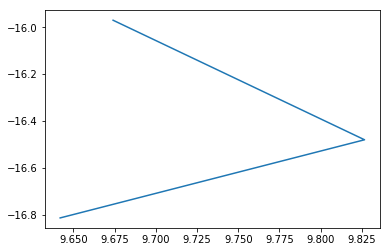

In [0]:
plot_lis2(train_rdplis[1])

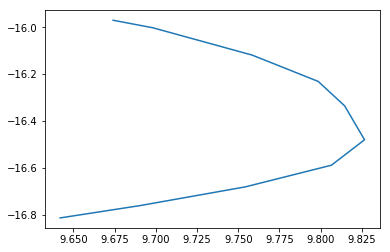

In [0]:
plot_lis2(train_merged[1])

In [0]:
dump_and_send(train_merged, "sym_rdp_longonly_train.pkl.gz")

Copying file://sym_rdp_longonly_train.pkl.gz [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/30.3 MiB.                                     


In [0]:
list3_to_max_stroke_len(valid_rdplis)

207

In [0]:
valid_merged = merge(valid_lis3, valid_rdplis, 207)

In [0]:
list3_to_max_stroke_len(valid_merged)

207

In [0]:
dump_and_send(valid_merged, "sym_rdp_longonly_valid.pkl.gz")

Copying file://sym_rdp_longonly_valid.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][  2.4 MiB/  2.4 MiB]                                                
Operation completed over 1 objects/2.4 MiB.                                      


In [0]:
dump_and_send(train_rdplis, "sym_rdplis_train.pkl.gz")

Copying file://sym_rdplis_train.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][ 19.5 MiB/ 19.5 MiB]                                                
Operation completed over 1 objects/19.5 MiB.                                     


In [0]:
def normalize_poslislis(poslislis):
    lislisarr = [np.array(one) for one in poslislis]
    maxpair = [one.max(0) for one in lislisarr]
    minpair = [one.min(0) for one in lislisarr]
    x_max = max(tup[0] for tup in maxpair)
    y_max = max(tup[1] for tup in maxpair)
    x_min = min(tup[0] for tup in minpair)
    y_min = min(tup[1] for tup in minpair)
    ratio = min(NORMALIZE_MAX/(0.0001+x_max-x_min), NORMALIZE_MAX/(0.0001+y_max-y_min))
    res = []
    for one in lislisarr:
      target = one.copy()
      target[:, 0] = (target[:, 0]-x_min)*ratio
      target[:, 1] = (target[:, 1]-y_min)*ratio
      res.append(target)
    return [one.astype(int) for one in res]


In [0]:
last_i=0

def list3_to_stroke_input_data(rdp_list3, maxstrokelen):
  global last_i
  stroke_input_data = np.zeros(
    (len(rdp_list3), maxstrokelen, INPUT_TYPE_DIM),
    dtype='int')
  for i, lislis in enumerate(rdp_list3):
    lislis = normalize_poslislis(lislis)
    last_i = i
    lislis = [np.array(poslis) for poslis in lislis]
    vec = poslislis2vec(lislis)
    stroke_input_data[i,0:vec.shape[0], : ] = vec
  return stroke_input_data

In [0]:
train_merge_stroke_input = list3_to_stroke_input_data(train_merged, 343)

In [0]:
train_merge_stroke_input.shape

(98289, 343, 3)

In [0]:
rdp_stroke_input.shape

(98289, 343, 3)

In [0]:
dump_and_send(train_merge_stroke_input, "sym_stroke_input_rdp_longonly_train.pkl.gz")

Copying file://sym_stroke_input_rdp_longonly_train.pkl.gz [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/18.4 MiB.                                     


In [0]:
list3_to_max_stroke_len(valid_merged)

207

In [0]:
valid_merge_stroke_input = list3_to_stroke_input_data(valid_merged, 207)

In [0]:
valid_merge_stroke_input.shape

(10019, 207, 3)

In [0]:
dump_and_send(valid_merge_stroke_input, "sym_stroke_input_rdp_longonly_valid.pkl.gz")

Copying file://sym_stroke_input_rdp_longonly_valid.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][  1.4 MiB/  1.4 MiB]                                                
Operation completed over 1 objects/1.4 MiB.                                      


In [0]:
train2 = [dic for dic in train_sym_raw_list if len(dic['strokes'])!=0]

In [0]:
dump_and_send(train2, "crohme2019_subtask_train_dict_removeempty.pkl.gz")

Copying file://crohme2019_subtask_train_dict_removeempty.pkl.gz [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/22.4 MiB.                                     


In [0]:
org_train_sym_raw_list = train_sym_raw_list
train_sym_raw_list = train2

In [0]:
valid_list3 = rawlist2lislislis(valid_sym_raw_list)

In [0]:
len(valid_list3)

10019

In [0]:
valid_rdplis = lislislis2rdplis(valid_list3)

In [0]:
list3_to_max_stroke_len(valid_rdplis)

207

In [0]:
rdp_stroke_input_valid = rdp_list3_to_stroke_input_data_nonnormalize(valid_rdplis, 207)

In [0]:
dump_and_send(rdp_stroke_input_valid, "sym_stroke_input_rdp_valid_nonnormalize.pkl.gz")

Copying file://sym_stroke_input_rdp_valid_nonnormalize.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][  1.0 MiB/  1.0 MiB]                                                
Operation completed over 1 objects/1.0 MiB.                                      


In [0]:
dump_and_send(valid_rdplis, "sym_rdplis_valid.pkl.gz")

Copying file://sym_rdplis_valid.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][  1.5 MiB/  1.5 MiB]                                                
Operation completed over 1 objects/1.5 MiB.                                      


### Write to TFRecord

In [0]:
# seems no int32
# https://www.tensorflow.org/tutorials/load_data/tf_records
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

In [0]:
def convert_to_example(one_stroke_sample, one_label_sample):
  example = tf.train.Example(features=tf.train.Features(feature={
      'input_x': _int64_feature(one_stroke_sample[:, 0]),
      'input_y': _int64_feature(one_stroke_sample[:, 1]),
      'input_type': _int64_feature(one_stroke_sample[:, 2]),
      'label':_int64_feature([one_label_sample])}))
  return example

In [0]:
convert_to_example(train_merge_stroke_input[0], train_sym_labels[0])

In [0]:
def write_to_file(filename, stroke, labels):
  with tf.python_io.TFRecordWriter(filename,
                                   tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)) as writer:
    for i in range(len(stroke)):
      example = convert_to_example(stroke[i], labels[i])
      writer.write(example.SerializeToString())


In [0]:
write_to_file("crohme2019_sym_rdp_longonly.tfrecord.gz", train_merge_stroke_input, train_sym_labels)

In [0]:
send_file("crohme2019_sym_rdp_longonly.tfrecord.gz")

Copying file://crohme2019_sym_rdp_longonly.tfrecord.gz [Content-Type=application/octet-stream]...
/ [1 files][ 15.4 MiB/ 15.4 MiB]                                                
Operation completed over 1 objects/15.4 MiB.                                     


In [0]:
write_to_file("crohme2019_sym_rdp_longonly_valid.tfrecord.gz", valid_merge_stroke_input, valid_sym_labels)

In [0]:
send_file("crohme2019_sym_rdp_longonly_valid.tfrecord.gz")

Copying file://crohme2019_sym_rdp_longonly_valid.tfrecord.gz [Content-Type=application/octet-stream]...
/ [1 files][  1.3 MiB/  1.3 MiB]                                                
Operation completed over 1 objects/1.3 MiB.                                      


# Try and error

### normalize check

In [0]:
ratio

1.3262598590013361

In [0]:
target = [one.copy() for one in lislisarr]

In [0]:
normalize_poslislis(train_merged[6])

[array([[ 876,  420],
        [ 876,  385],
        [ 876,  385],
        [ 840,  420],
        [ 806,  492],
        [ 736,  561],
        [ 700,  665],
        [ 665,  771],
        [ 629,  842],
        [ 629,  948],
        [ 629, 1017],
        [ 665, 1087],
        [ 700, 1157],
        [ 736, 1193],
        [ 806, 1193],
        [ 876, 1157],
        [ 946, 1122],
        [1017, 1053],
        [1087,  982],
        [1122,  876],
        [1157,  771],
        [1157,  701],
        [1157,  596],
        [1122,  492],
        [1087,  420],
        [1017,  385],
        [ 946,  351],
        [ 876,  385],
        [ 806,  385],
        [ 770,  420],
        [ 700,  456],
        [ 665,  456]]), array([[ 175,  245],
        [ 175,  245],
        [ 175,  245],
        [ 140,  245],
        [ 104,  281],
        [ 104,  351],
        [  70,  420],
        [  34,  526],
        [   0,  665],
        [   0,  807],
        [   0,  948],
        [  34, 1053],
        [  70, 1157],
        [

In [0]:
res

[array([[ 876.6577668 ,  420.4243753 ],
        [ 876.6577668 ,  385.94161897],
        [ 876.6577668 ,  385.94161897],
        [ 840.84875061,  420.4243753 ],
        [ 806.36599427,  492.04240769],
        [ 736.07422175,  561.00792036],
        [ 700.26520555,  665.78244922],
        [ 665.78244922,  771.88323794],
        [ 629.97343303,  842.17501047],
        [ 629.97343303,  948.27579919],
        [ 629.97343303, 1017.24131185],
        [ 665.78244922, 1087.53308438],
        [ 700.26520555, 1157.82485691],
        [ 736.07422175, 1193.6338731 ],
        [ 806.36599427, 1193.6338731 ],
        [ 876.6577668 , 1157.82485691],
        [ 946.94953933, 1122.01584072],
        [1017.24131185, 1053.05032805],
        [1087.53308438,  982.75855552],
        [1122.01584072,  876.6577668 ],
        [1157.82485691,  771.88323794],
        [1157.82485691,  701.59146541],
        [1157.82485691,  596.81693655],
        [1122.01584072,  492.04240769],
        [1087.53308438,  420.4243753 ],


In [0]:
x_min, x_max, y_min, y_max

(9102.0, 10610.0, 3704.0, 4735.0)

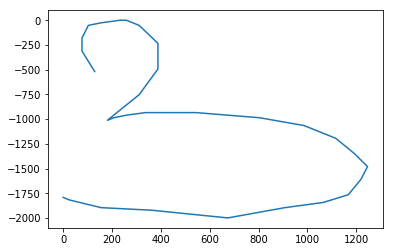

In [0]:
plot_lis2(normalize_poslislis(train_merged[4]))

In [0]:
min(tup[0] for tup in minpair)

9102.0

In [0]:
target = train_merged[6].copy()

In [0]:
one_lis2arr = [np.array(one) for one in one_lis2]

In [0]:
x_max, y_max = one_lis2arr[0].max(0)

In [0]:
x_min, y_min  = one_lis2arr[0].min(0)

In [0]:
x_aligned = one_lis2arr[0][:, 0]-x_min

In [0]:
x_aligned

array([0.2568, 0.2608, 0.2568, 0.2528, 0.2528, 0.2448, 0.2448, 0.2448,
       0.2488, 0.2367, 0.2408, 0.2247, 0.2046, 0.1806, 0.1725, 0.1685,
       0.1525, 0.1324, 0.1083, 0.0762, 0.0441, 0.0161, 0.    , 0.004 ,
       0.004 , 0.008 , 0.008 , 0.0161, 0.0241, 0.0321, 0.0522, 0.0762,
       0.1204, 0.1685, 0.2287, 0.2688, 0.305 , 0.333 , 0.3611, 0.3812])

In [0]:
x_max, y_max

(12.523, 16.873)

In [0]:
one_lis2arr[0].max((0, 1))

16.873

In [0]:
res = normalize_poslislis(train_merged[0])

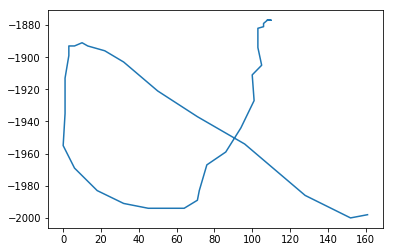

In [0]:
plot_lis2(res)

### Encoder input setup

In [0]:
rdp_stroke_input = get_and_load("stroke_sym_input_rdp_train_nonnormalize.pkl.gz")
rdp_stroke_input_valid = get_and_load("stroke_sym_input_rdp_valid_nonnormalize.pkl.gz")

Copying gs://karino2-tegashiki/dataset/stroke_input_rdp_train.pkl.gz...
/ [1 files][ 10.6 MiB/ 10.6 MiB]                                                
Operation completed over 1 objects/10.6 MiB.                                     
Copying gs://karino2-tegashiki/dataset/stroke_input_rdp_valid.pkl.gz...
/ [1 files][977.8 KiB/977.8 KiB]                                                
Operation completed over 1 objects/977.8 KiB.                                    


In [0]:
poslislis = strokearr2poslislis(train_sym_raw_list[6]["strokes"])

In [0]:


def input_fn_with_batch(batch_size):
  ds_inputs = tf.data.Dataset.from_tensor_slices(({"input_stroke": stroke_input, "input_decoder": decoder_input_data}, decoder_sparse_target_data))
  # ds_inputs = tf.data.Dataset.from_tensor_slices(({"input_stroke": stroke_input[0:14], "input_decoder": decoder_input_data[0:14]}, decoder_target_data[0:14]))
  return ds_inputs.repeat().batch(batch_size)

def input_fn():
  return input_fn_with_batch(8)
  # ds_stroke = tf.data.Dataset.from_tensor_slices(stroke_input)
  # ds_decoder_input = tf.data.Dataset.from_tensor_slices(decoder_input_data)
  # ds_labels = tf.data.Dataset.from_tensor_slices(decoder_target_data)
  # ds_inputs = tf.data.Dataset.zip((ds_stroke, ds_decoder_input))
  # return tf.data.Dataset.zip((ds_inputs, ds_labels)).repeat().batch(200)

In [0]:
def model_fn(features, labels, mode, params):
  # input_from_enc = features["input_from_encoder"] # tf.feature_column.input_layer(features, params['input_from_enc'])
  # input_for_dec= features['decoder_input'] # tf.feature_column.input_layer(features, params['input_for_dec'])
  input_stroke = tf.feature_column.input_layer(features, params['input_stroke'])
  input_for_dec= tf.feature_column.input_layer(features, params['input_for_dec'])
  # input_from_enc = tf.expand_dims(input_from_enc, axis=0)
  #input_for_dec = tf.expand_dims(input_for_dec, axis=0)
  # labels = tf.expand_dims(labels, axis=0)
  # print(features["decoder_input"])
  # print(features["decoder_input"])
  # print(features["input_from_encoder"])
  input_stroke = tf.reshape(input_stroke, shape=(-1, MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM))
  print("model_fn, stroke, inputdec, label")
  print(input_stroke.shape)
  print(input_for_dec.shape)
  print(labels.shape)
  print(features["input_stroke"])
  
  logit = create_model(input_stroke, input_for_dec)
  
  
  predicted_classes = tf.math.argmax(logit,axis=2)
  # print("predclass")
  # print(predicted_classes.shape)
  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        'logit': logit,
        'class_ids': predicted_classes
        #        'class_ids': predicted_classes[:, :, tf.newaxis],
        #    'probabilities': tf.nn.softmax(logits),
        #    'logits': logits,
    }
    return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # print(labels.shape)
  # print(logit.shape)
  loss = tf.losses.sparse_softmax_cross_entropy(labels, logit)


  accuracy = tf.metrics.accuracy(labels=labels,
                                 predictions=predicted_classes,
                                 name='acc_op')
  
  metrics = {'accuracy': accuracy}
  tf.summary.scalar('accuracy', accuracy[1])

  if mode == tf.estimator.ModeKeys.EVAL:
    return tf.estimator.EstimatorSpec(
        mode, loss=loss, eval_metric_ops=metrics)
  
  optimizer = tf.train.AdamOptimizer(params['learning_rate'])
  train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
  
  return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [0]:
MAX_TRAIN_LEN

90

In [0]:
MAX_STROKE_SEQ_LEN

2773

In [0]:
tf.feature_column.numeric_column(key="input_stroke", shape=(MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM))

NumericColumn(key='input_stroke', shape=(2773, 3), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [0]:
tf.feature_column.numeric_column(key="input_decoder", shape=(MAX_TRAIN_LEN,))

NumericColumn(key='input_decoder', shape=(90,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [0]:
decoder_input_data.shape

NameError: ignored

In [0]:
3*2773

8319

In [0]:
stroke_input.shape

(8190, 2773, 3)

In [0]:
for _ in range(100):
  estimator.train(
    input_fn=input_fn,
    steps=14)

In [0]:
print(estimator.model_dir)

In [0]:
!cp -r /tmp/tmpsprjnv8j ./estimator_model1_dir

In [0]:
for i, row in train_labels.iterrows():
    seq = [BEGIN_OF_SEQ] + [int(s) for s in row['exp_ids'].split(",")]
    decoder_input_data[i, 0:len(seq)] =seq
    decoder_target_data[i, 0:(len(seq)-1), :] =  np.eye(VOCAB_SIZE)[decoder_input_data[i, 1:len(seq)]]
    decoder_sparse_target_data[i, 0:(len(seq)-1)] =  decoder_input_data[i, 1:len(seq)]

In [0]:
decoder_input_data.shape

(8190, 90)

In [0]:
decoder_target_data.shape

(8190, 90, 112)

In [0]:
decoder_input_data[0, 0:5]

array([111,  77,  47,  65,   7], dtype=uint8)

In [0]:
decoder_target_data[0, 0:3, 40:50]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [0]:
stroke_input.shape

(8190, 2773, 3)

In [0]:
decoder_input_data.shape

(8190, 90)

In [0]:
bs = 32

In [0]:
def create_generator(x, batch_size):
    for i in range(len(x)//batch_size):
        yield x[i*batch_size : (i+1)*batch_size]


In [0]:
tmp = tf.data.Dataset.from_generator(create_generator, (tf.int32),
                                             (tf.TensorShape([None, MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM])),
                                             args = ([stroke_input, bs]))


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [0]:
tmp

<DatasetV1Adapter shapes: (?, 2773, 3), types: tf.int32>

In [0]:
def create_generator(x, batch_size):
    for i in range(len(x)//batch_size):
        yield x[i*batch_size : (i+1)*batch_size]

def tpu_input_fn(params):
  bs = params['batch_size'] 
  ds_stroke = tf.data.Dataset.from_generator(create_generator, (tf.int32),
                                             (tf.TensorShape([None, MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM])),
                                             args = ([stroke_input, bs]))
                                             
  ds_decoder_input = tf.data.Dataset.from_generator(create_generator, (tf.int32),
                                             (tf.TensorShape([None, MAX_TRAIN_LEN]),
                                              args = ([decoder_input_data.astype(np.int32), bs]))
  ds_labels = tf.data.Dataset.from_generator(create_generator, (tf.int32),
                                             (tf.TensorShape([None, MAX_TRAIN_LEN, VOCAB_SIZE]),
                                              args = ([decoder_target_data.astype(np.int32), bs]))
  
  
    # ds_stroke = tf.data.Dataset.from_tensor_slices(stroke_input)
  # ds_decoder_input = tf.data.Dataset.from_tensor_slices(decoder_input_data)
  # ds_labels = tf.data.Dataset.from_tensor_slices(decoder_target_data)
  # ds_inputs = tf.data.Dataset.zip((ds_stroke, ds_decoder_input))
  # return tf.data.Dataset.zip((ds_inputs, ds_labels)).repeat().batch(200)
  
  
  train_data = Data.Dataset.from_generator( generator= data_gen,
                                             output_types= ( tf.float32, tf.int32),
                                             output_shapes= ((bs, 28,28),(bs)) )

In [0]:
def data_gen(x=x_train , y= y_train, batch_size = 32 ):
    
    for i in range(len(x)//batch_size):
        yield (x[i*batch_size : (i+1)*batch_size], y[i*batch_size : (i+1)*batch_size])

        
        


In [0]:
BATCH_SIZE=16

In [0]:
def create_input_fn(batch_size):
  input_fn = tf.estimator.inputs.numpy_input_fn({"input_stroke": stroke_input,
                       "input_decoder": decoder_input_data.astype(np.int32)},
                        decoder_target_data.astype(np.int32),
                       batch_size=batch_size,
                       shuffle=True)
  return lambda params: input_fn()

In [0]:
def tpu_input_fn(params):
  return tf.estimator.inputs.numpy_input_fn({"input_stroke": stroke_input, "input_decoder": decoder_input_data},
                        decoder_target_data,
                       batch_size=params['batch_size'],
                       shuffle=True)


In [0]:
def tpu_input_fn_wrapper(params):
  # test_ds = tf.data.Dataset.from_tensor_slices(fdict)    
  # return test_ds.batch(params['batch_size'])
  # return input_fn_with_batch(params['batch_size'])
  #
  #TPU does not support uint8 as infeed type.
  ds_inputs = tf.data.Dataset.from_tensor_slices(({"input_stroke": stroke_input, 
                                                   "input_decoder": decoder_input_data.astype(np.int32)}, decoder_target_data.astype(np.int32)))
  ds = ds_inputs.shuffle(1000).repeat()
  ds = ds.batch(params['batch_size'], drop_remainder=True)
  return ds



In [0]:
  example = tf.train.Example(features=tf.train.Features(feature={
      'input_x': _int64_feature(one_stroke_sample[:, 0]),
      'input_y': _int64_feature(one_stroke_sample[:, 1]),
      'input_type': _int64_feature(one_stroke_sample[:, 2]),
      'decoder_input':_int64_feature(one_decoder_sample),
      'decoder_labels':_int64_feature(one_label_sample)}))


In [0]:
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu=FLAGS.tpu_name)

is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2

run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    master=FLAGS.master,
    model_dir=FLAGS.output_dir,
    save_checkpoints_steps=FLAGS.save_checkpoints_steps,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=FLAGS.iterations_per_loop,
        num_shards=FLAGS.num_tpu_cores,
        per_host_input_for_training=is_per_host))

In [0]:
def tpu_model_fn_wrapper(features, labels, mode, params):
  tspec = model_fn(features, labels, mode, params)
  pred_dict = {'predictions': tspec.predictions}
  return tf.contrib.tpu.TPUEstimatorSpec(
          mode=tspec.mode, predictions=pred_dict, scaffold_fn=tspec.scaffold_fn)

In [0]:
tpu_estimator = tf.contrib.tpu.TPUEstimator(
    model_fn=model_fn,
    config=tf.contrib.tpu.RunConfig(),
    use_tpu=False)

In [0]:
class FLAGS(object):
    '''Parameters.'''
    def __init__(self):
        self.use_tpu = True
        self.output_dir = "gs://karino2-tegashiki/models/model1"
        # self.data_dir = "./bert/data/1000"
        self.init_checkpoint = INIT_CHECK_POINT
        # self.predict_batch_size = 16
        self.predict_batch_size = 1
        # TPU related
        self.num_tpu_cores = 8
        self.tpu_name = TPU_ADDRESS
        
        # self.max_seq_length = 512
        
        # The following parameters are not used in predictions.
        # Just use to create RunConfig.
        self.master = None
        self.save_checkpoints_steps = 1
        self.learning_rate = 0
        self.num_warmup_steps = 0
        self.num_train_steps = 0
        # TPU related. Some of these value have positive int not to make TPUEstimator angry (even though these are not used...).
        # self.eval_batch_size = 32
        # self.train_batch_size = 32 
        self.eval_batch_size = 1
        self.train_batch_size = 1 
        self.iterations_per_loop = 1000


In [0]:
import subprocess

use_tpu=False
tpu_name=None
model_dir = "gs://karino2-tegashiki/models/model1"
iterations = 50
num_shards = 8

my_project_name = subprocess.check_output([
    'gcloud','config','get-value','project'])
my_zone = subprocess.check_output([
    'gcloud','config','get-value','compute/zone'])

cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)


cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
        tpu_names=[FLAGS.tpu_name],
        zone=my_zone,
        project=my_project)
master = tpu_cluster_resolver.get_master()

In [0]:
import subprocess

use_tpu=False
tpu_name=None
model_dir = "estimator_model1_dir"
iterations = 50
num_shards = 8

my_project_name = subprocess.check_output([
    'gcloud','config','get-value','project'])
my_zone = subprocess.check_output([
    'gcloud','config','get-value','compute/zone'])
cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
        tpu_names=[FLAGS.tpu_name],
        zone=my_zone,
        project=my_project)
master = tpu_cluster_resolver.get_master()

In [0]:
tpu_run_config = tf.contrib.tpu.RunConfig(
    master=master,
    evaluation_master=master,
    model_dir=FLAGS.model_dir,
    session_config=tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=True),
    tpu_config=tf.contrib.tpu.TPUConfig(FLAGS.iterations,
                                        FLAGS.num_shards),
)

In [0]:
tpu_estimator = tf.contrib.tpu.TPUEstimator(
    model_fn=model_fn,
    config=tf.contrib.tpu.RunConfig(),
    use_tpu=False)

In [0]:
tf.logging.set_verbosity(tf.logging.WARN)

In [0]:
inp = input_fn()

In [0]:
inp

In [0]:
while True:
  try:
    print(sess.run(inp[0]['decoder_input']))
  except tf.errors.OutOfRangeError:
    break

In [0]:
res = list(estimator.predict(
    input_fn=eval_input_fn))

In [0]:
res

In [0]:
input1, input2, yt = create_model()

In [0]:
# (batch, 98, 112)
decoder_label_t = tf.placeholder(tf.int8, shape=[None, MAX_TRAIN_LEN, VOCAB_SIZE])

In [0]:
loss = tf.losses.softmax_cross_entropy(decoder_label_t, yt)

In [0]:
# optimizer = tf.train.AdamOptimizer(0.00009)
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)

### Check MAX

In [0]:
train_labels["exp_ids"].map(lambda x: len(x.split(","))).max()

88

In [0]:
# check validation set max
valid_labels = rawlabels2df(valid_raw_list)
valid_labels["exp_ids"].map(lambda x: len(x.split(","))).max()

206

In [0]:
sum(tup.split(","))

In [0]:
train_raw_list[0][4]

['10.7816 21.4071, 10.7776 21.3991, 10.7896 21.4031, 10.8097 21.4071, 10.8418 21.3951, 10.9019 21.375, 10.9782 21.3309, 11.0705 21.2867, 11.1226 21.2386, 11.1587 21.1904, 11.1708 21.1342, 11.1708 21.066, 11.1427 20.9858, 11.1066 20.9296, 11.0825 20.9176, 11.0745 20.9216, 11.0624 20.9336, 11.0464 20.9978, 11.0263 21.062, 11.0303 21.1503, 11.0384 21.2426, 11.0544 21.3268, 11.0705 21.4392, 11.0785 21.5235, 11.0865 21.5877, 11.0865 21.6398, 11.0905 21.6639, 11.0945 21.688, 11.0905 21.688',
 '11.0063 21.4793, 11.0103 21.4753, 11.0143 21.4753, 11.0344 21.4713, 11.0865 21.4673, 11.1467 21.4633, 11.2591 21.4472',
 '11.5199 21.4472, 11.4958 21.4472, 11.4757 21.4472, 11.4557 21.4352, 11.4476 21.4352, 11.4396 21.4151, 11.4436 21.3991, 11.4517 21.387, 11.4677 21.367, 11.4958 21.363, 11.5159 21.375, 11.5439 21.383, 11.552 21.4071, 11.552 21.4272, 11.5319 21.4352, 11.4918 21.4753, 11.4476 21.5074, 11.4196 21.5475, 11.4196 21.5676, 11.4236 21.5756, 11.4436 21.5877, 11.5159 21.6077, 11.6282 21.6157',


In [0]:
def calc_stroke_len(strokearr):
  return len(strokearr)+ sum(len(stroke.split(",")) for stroke in strokearr)

In [0]:
#MAX_STROKE_SEQ_LEN
max(calc_stroke_len(tup[4]) for tup in train_raw_list)

3193

In [0]:
max(calc_stroke_len(tup[4]) for tup in valid_raw_list)

6620

In [0]:
!pip install rdp

In [0]:
from rdp import rdp

In [0]:
def calc_stroke_len_with_rdp(strokearr, epsilon=0.05):
  poslislis = strokearr2poslislis(strokearr)
  return len(poslislis)+sum(len(rdp(one, epsilon=epsilon)) for one in poslislis)

In [0]:
max(calc_stroke_len_with_rdp(tup[4]) for tup in train_raw_list)

In [0]:
%%time

max(calc_stroke_len_with_rdp(tup[4]) for tup in valid_raw_list)

In [0]:
len(train_labels)

NameError: ignored

In [0]:
stroke_input.shape

(8190, 2773, 3)

In [0]:
#  # (batch, times, 3)
# input_from_encoder_t = tf.placeholder(tf.float32, shape=[None, MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM])


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
decoder_input_t = tf.placeholder(tf.int8, shape=[None, MAX_TRAIN_LEN])


In [0]:
w1 = Dense(HIDDEN_SIZE)(ht_enc)
# w1 (sample, None, 256)
w2 = Dense(HIDDEN_SIZE)(ht_dec)


In [0]:
w1.shape

TensorShape([Dimension(None), Dimension(276), Dimension(256)])

In [0]:
w2.shape

TensorShape([Dimension(None), Dimension(90), Dimension(256)])

In [0]:
w2_widen = tf.expand_dims(w2, axis=1)
# (sample, 1, 90, 256)

w1_widen = tf.expand_dims(w1, axis=2)
# (sample, 276, 1, 256)

w1_widen_repeat = K.repeat_elements(w1_widen, rep=MAX_TRAIN_LEN, axis=2)
# (sample, 276, 90, 256)


In [0]:
w1_widen_repeat.shape

TensorShape([Dimension(None), Dimension(276), Dimension(90), Dimension(256)])

In [0]:
w2_widen.shape

TensorShape([Dimension(None), Dimension(1), Dimension(90), Dimension(256)])

In [0]:
score =tf.nn.tanh(w1_widen_repeat+w2_widen)
prob = Dense(1, activation="softmax")(score)


In [0]:
score.shape

TensorShape([Dimension(None), Dimension(276), Dimension(90), Dimension(256)])

In [0]:
prob.shape

TensorShape([Dimension(None), Dimension(276), Dimension(90), Dimension(1)])

In [0]:
prob.shape

TensorShape([Dimension(None), Dimension(276), Dimension(90), Dimension(1)])

In [0]:
ht_enc.shape

TensorShape([Dimension(None), Dimension(276), Dimension(256)])

In [0]:
ht_enc_repeated

<tf.Tensor 'concat_1:0' shape=(?, 276, 90, 256) dtype=float32>

In [0]:
context_vec = tf.reduce_sum(prob*ht_enc_repeated, axis=1)


In [0]:
context_vec.shape

TensorShape([Dimension(None), Dimension(90), Dimension(256)])

In [0]:
logit.shape

TensorShape([Dimension(None), Dimension(90), Dimension(112)])

### rdp trial

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
def listi(lis, pos):
  return np.array([tup[pos] for tup in lis])

In [0]:
def plot_lis2(lislis):
  for i in range(len(lislis)):
    plt.plot(listi(lislis[i], 0),-listi(lislis[i], 1))

In [0]:
!pip install rdp

  Stored in directory: /root/.cache/pip/wheels/76/e4/02/c738593caece49c63180d093651bec3cd3b02ea3248f076f07
Successfully built rdp


In [0]:
from rdp import rdp

In [0]:
stroke_input.shape

(9862, 3193, 3)

In [0]:
train_raw_list[0][4]

['10.7816 21.4071, 10.7776 21.3991, 10.7896 21.4031, 10.8097 21.4071, 10.8418 21.3951, 10.9019 21.375, 10.9782 21.3309, 11.0705 21.2867, 11.1226 21.2386, 11.1587 21.1904, 11.1708 21.1342, 11.1708 21.066, 11.1427 20.9858, 11.1066 20.9296, 11.0825 20.9176, 11.0745 20.9216, 11.0624 20.9336, 11.0464 20.9978, 11.0263 21.062, 11.0303 21.1503, 11.0384 21.2426, 11.0544 21.3268, 11.0705 21.4392, 11.0785 21.5235, 11.0865 21.5877, 11.0865 21.6398, 11.0905 21.6639, 11.0945 21.688, 11.0905 21.688',
 '11.0063 21.4793, 11.0103 21.4753, 11.0143 21.4753, 11.0344 21.4713, 11.0865 21.4673, 11.1467 21.4633, 11.2591 21.4472',
 '11.5199 21.4472, 11.4958 21.4472, 11.4757 21.4472, 11.4557 21.4352, 11.4476 21.4352, 11.4396 21.4151, 11.4436 21.3991, 11.4517 21.387, 11.4677 21.367, 11.4958 21.363, 11.5159 21.375, 11.5439 21.383, 11.552 21.4071, 11.552 21.4272, 11.5319 21.4352, 11.4918 21.4753, 11.4476 21.5074, 11.4196 21.5475, 11.4196 21.5676, 11.4236 21.5756, 11.4436 21.5877, 11.5159 21.6077, 11.6282 21.6157',


In [0]:
poslislis = strokearr2poslislis(one_stroke_list)

In [0]:
len(poslislis)

6

In [0]:
len(poslislis[0])

29

In [0]:
rdp(poslislis[0], epsilon=1.0)

[[10.7816, 21.4071], [11.0905, 21.688]]

In [0]:
rdp(poslislis[1], epsilon=1.0)

[[11.0063, 21.4793], [11.2591, 21.4472]]

In [0]:
poslislis[1]

[(11.0063, 21.4793),
 (11.0103, 21.4753),
 (11.0143, 21.4753),
 (11.0344, 21.4713),
 (11.0865, 21.4673),
 (11.1467, 21.4633),
 (11.2591, 21.4472)]

In [0]:
rdp(poslislis[2], epsilon=0.5)

[[11.5199, 21.4472], [11.6282, 21.6157]]

In [0]:
poslislis[2]

[(11.5199, 21.4472),
 (11.4958, 21.4472),
 (11.4757, 21.4472),
 (11.4557, 21.4352),
 (11.4476, 21.4352),
 (11.4396, 21.4151),
 (11.4436, 21.3991),
 (11.4517, 21.387),
 (11.4677, 21.367),
 (11.4958, 21.363),
 (11.5159, 21.375),
 (11.5439, 21.383),
 (11.552, 21.4071),
 (11.552, 21.4272),
 (11.5319, 21.4352),
 (11.4918, 21.4753),
 (11.4476, 21.5074),
 (11.4196, 21.5475),
 (11.4196, 21.5676),
 (11.4236, 21.5756),
 (11.4436, 21.5877),
 (11.5159, 21.6077),
 (11.6282, 21.6157)]

In [0]:
plt.plot(listi(poslislis[0], 0),-listi(poslislis[0], 1))
plt.plot(listi(poslislis[1], 0),-listi(poslislis[1], 1))
plt.plot(listi(poslislis[2], 0),-listi(poslislis[2], 1))
plt.plot(listi(poslislis[3], 0),-listi(poslislis[3], 1))
plt.plot(listi(poslislis[4], 0),-listi(poslislis[4], 1))
plt.plot(listi(poslislis[5], 0),-listi(poslislis[5], 1))

In [0]:
rdplislis = [rdp(lis, epsilon=0.5) for lis in poslislis]

In [0]:
rdplislis = train_rdplis[1]

In [0]:
train_sym_raw_list[1]['symbol']

')'

### data check

some data seems too simplify.
But some data seems too noisy.

I decide rdp reduction only for long stroke.
Long is defined by max length of all rdp-ed strokes.

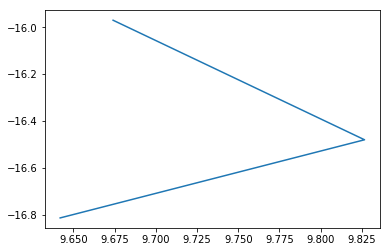

In [0]:
plot_lis2(train_rdplis[1])

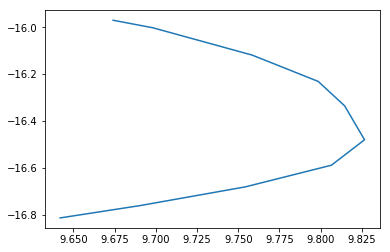

In [0]:
plot_lis2(lislislis[1])

In [0]:
lislislis = rawlist2lislislis(train_sym_raw_list)

In [0]:
train_lis3 = lislislis

In [0]:
valid_lis3 = rawlist2lislislis(valid_sym_raw_list)

In [0]:
len(lislislis)

98290

In [0]:
len(poslislis[0])

32

In [0]:
len(lislislis[6][0])

32

In [0]:
train_rdplis = lislislis2rdplis(lislislis)

In [0]:
def list3_to_max_stroke_len(list3):
  return max([len(poslislis)+sum(len(one) for one in poslislis) for poslislis in list3])


In [0]:
list3_to_max_stroke_len(valid_lis3)

1621

In [0]:
def list3_to_indexlen(list3):
  return [(i, len(poslislis)+sum(len(one) for one in poslislis)) for i, poslislis in enumerate(list3)]

In [0]:
val_index_len_pair = [(i, len(poslislis)+sum(len(one) for one in poslislis)) for i, poslislis in enumerate(valid_lis3)]

In [0]:
len([tup for tup in val_index_len_pair if tup[1] > 616])

28

In [0]:
[tup for tup in val_index_len_pair if tup[1] > 616]

[(689, 713),
 (1197, 718),
 (2473, 768),
 (2691, 787),
 (3024, 877),
 (3103, 677),
 (3347, 675),
 (4178, 758),
 (4478, 705),
 (4614, 861),
 (5010, 942),
 (5899, 627),
 (5940, 626),
 (5944, 710),
 (6353, 694),
 (6913, 1621),
 (7036, 804),
 (7050, 648),
 (7519, 629),
 (7614, 678),
 (7682, 656),
 (8245, 679),
 (8599, 720),
 (8983, 721),
 (9364, 652),
 (9544, 800),
 (9668, 1062),
 (9898, 634)]

In [0]:
valid_sym_raw_list[9668]

{'path': 'valid/isolated_testSymbols2014/testSymbols/iso166.inkml',
 'strokes': ['208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 207 61, 207 61, 207 61, 207 61, 207 61, 207 61, 205 62, 205 62, 202 63, 202 63, 202 63, 202 63, 202 63, 202 63, 202 63, 202 63, 201 63, 201 63, 201 63, 201 63, 200 64, 200 64, 200 64, 199 65, 199 65, 199 65, 198 66, 198 66, 198 66, 198 66, 196 67, 196 67, 196 67, 196 67, 196 68, 196 68, 196 68, 193 70, 193 70, 193 70, 192 70, 192 70, 192 70, 191 72, 191 72, 191 72, 191 72, 191 72, 190 73, 190 73, 188 74, 188 74, 188 75, 188 75, 188 75, 188 75, 188 75, 188 75, 188 75, 187 77, 187 77, 187 77, 187 77, 187 77, 186 79, 186 79, 186 79, 184 80, 184 80, 184 80, 184 80, 184 80, 184 82, 184 82, 184 82, 183 84, 183 84, 183 84, 183 84, 183 84, 183 84, 183 84, 183 85

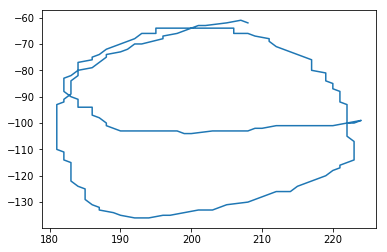

In [0]:
plot_lis2(valid_lis3[9668])

In [0]:
valid_rdplis = get_and_load("sym_rdplis_valid.pkl.gz")

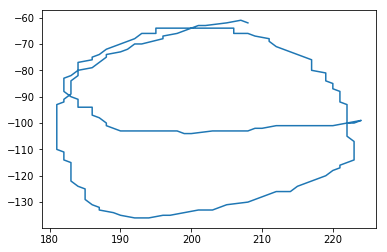

In [0]:
plot_lis2(valid_rdplis[9668])

In [0]:
sum(len(stroke) for stroke in valid_rdplis[9668])

104

In [0]:
def lis2_len(lislis):
  return len(lislis)+sum(len(one) for one in lislis)


In [0]:
lis2_len(valid_lis3[9668])

1062

In [0]:
sum(len(stroke) for stroke in valid_lis3[9668])

1061

In [0]:
train_indlen = list3_to_indexlen(train_lis3)

In [0]:
[tup for tup in train_indlen if tup[1] > 500]

[(48681, 501),
 (49821, 519),
 (52936, 531),
 (53457, 601),
 (77407, 616),
 (80168, 597),
 (94532, 513)]

In [0]:
MAX_STROKE_SEQ_LEN=343

1948

In [0]:
list3_to_max_stroke_len(lislislis)

616

343

In [0]:
list3_to_max_stroke_len(valid_rdplis)

207

In [0]:
len(train_rdplis), len(train_lis3)

(98290, 98289)

In [0]:
input_from_encoder_t = tf.placeholder(tf.float32, shape=[None, None, None, ENC_OUTPUT_DIM])
#  # (batch, 98)
decoder_input_t = tf.placeholder(tf.int8, shape=[None, MAX_TRAIN_LEN])


In [0]:
input_from_encoder_t.shape

In [0]:
flattened_enc_output = Reshape((-1, ENC_OUTPUT_DIM))(input_from_encoder_t)
masked_input_from_enc = Masking(mask_value = np.nan,input_shape=(None, ENC_OUTPUT_DIM))(flattened_enc_output)


In [0]:
rdp_stroke_input.shape

(9862, 1948, 3)

In [0]:
def list3_to_stroke_len(list3):
  return [len(poslislis)+sum(len(one) for one in poslislis) for poslislis in list3]


In [0]:
train_lens = list3_to_stroke_len(train_rdplis)

In [0]:
len(train_lens)

9862

(array([1.383e+03, 1.258e+03, 9.100e+02, 7.090e+02, 6.070e+02, 5.320e+02,
        5.270e+02, 4.430e+02, 4.320e+02, 3.800e+02, 3.860e+02, 3.670e+02,
        3.130e+02, 2.470e+02, 2.330e+02, 2.150e+02, 1.830e+02, 1.240e+02,
        1.060e+02, 8.600e+01, 8.400e+01, 8.200e+01, 5.000e+01, 3.900e+01,
        4.300e+01, 2.300e+01, 2.100e+01, 1.500e+01, 5.000e+00, 1.400e+01,
        1.000e+01, 4.000e+00, 6.000e+00, 6.000e+00, 2.000e+00, 1.000e+00,
        6.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([   9.  ,   47.78,   86.56,  125.34,  164.12,  202.9 ,  241.68,
         280.46,  319.24,  358.02,  396.8 ,  435.58,  474.36,  513.14,
         551.92,  590.7 ,  629.48,  668.26,  707.04,  745.82,  784.6 ,
         823.38,  862.16,  900.94,  939.72,  978.5 , 1017.28, 1056.06,
        1094.84, 1133.62, 1172.4 , 1211.18, 1249.96, 1288.74, 1327.52,
        1366.3 , 1405

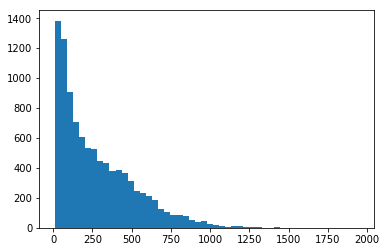

In [0]:
plt.hist(train_lens, bins=50)

In [0]:
(np.array(train_lens)<500).sum()

8131

In [0]:
(np.array(train_lens)>=500).sum()

1731

### TCN n estimate

In [0]:
import math

In [0]:
1+499/14

36.642857142857146

In [0]:
# 1+2*(k-1)*(2^n-1) #> 500
# 1+2*7*(2^n-1) > 500
# 2^n-1 > 499/14
# 2^n > 1+499/14
math.log2(1+ (499/14.0))

5.19546009354945

I set n = 6

In [0]:
# for target == 2000 case
math.log2(1+ (1999/14.0))

7.1677765348637354

In [0]:
# for target == 300 case
math.log2(1+ (300/14.0))

4.487265826834022

In [0]:
2**0

1

### Misc

In [0]:
def encoder_TCN(input_from_encoder_t):
  conved = TCN(input_from_encoder_t)

  # state_for_dec = Dense(GRU_HIDDEN, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(conved[:, -1, :])
  
  # pooled = AveragePooling1D(10)(conved)
  return pooled, state_for_dec

def encoder_CNNRNN(input_from_encoder_t, dropout_rate=DROPOUT_RATE):
  conved = Conv1D(32, 7, activation='relu', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(input_from_encoder_t)
  pooled = AveragePooling1D(10)(conved)

  ht_enc, state_enc = GRU(GRU_HIDDEN, return_sequences=True,return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), recurrent_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(pooled)
  return ht_enc, state_enc

In [0]:
import tensorflow as tf

In [0]:
dataset = tf.data.TFRecordDataset(TF_RECORD_FILE, "GZIP")


NameError: ignored

In [0]:
dataset = dataset.map(parser_train)

In [0]:
dataset.filter(lambda dec, strk: )

In [0]:
oneiter = dataset.take(3).make_one_shot_iterator()

In [0]:
oneiter.get_next()

({'input_decoder': <tf.Tensor 'IteratorGetNext:0' shape=(90,) dtype=int32>,
  'input_stroke': <tf.Tensor 'IteratorGetNext:1' shape=(5844,) dtype=int32>},
 <tf.Tensor 'IteratorGetNext:2' shape=(90,) dtype=int32>)

In [0]:
sess = tf.InteractiveSession()

In [0]:
obj = sess.run(oneiter.get_next())

In [0]:
obj[0]['input_stroke']

array([[ 986, 1959,    1],
       [1021, 1939,    1],
       [1016, 1915,    1],
       ...,
       [   0,    0,    0],
       [   0,    0,    0],
       [   0,    0,    0]], dtype=int32)

In [0]:
obj[0]['input_stroke'].reshape(-1, 3).argmin(END_OF_SEQ)

2

In [0]:
obj[0]['input_stroke'].reshape(-1, 3)

array([[ 986, 1021, 1016],
       [1009, 1015,    0],
       [1007, 1030,    0],
       ...,
       [   0,    0,    0],
       [   0,    0,    0],
       [   0,    0,    0]], dtype=int32)

In [0]:
obj[0]['input_stroke'][0:10]

array([648, 630,   0, 626, 654,   0, 657, 667, 661, 673], dtype=int32)

In [0]:
obj[0]['input_stroke'].reshape(-1, 3)[0:20]

array([[648, 630,   0],
       [626, 654,   0],
       [657, 667, 661],
       [673,   0, 698],
       [675,   0, 684],
       [689,   0, 724],
       [724, 735, 735],
       [739, 737, 725],
       [  0, 750, 761],
       [751, 764,   0],
       [616, 770,   0],
       [683, 682, 670],
       [666, 676, 681],
       [690,   0, 695],
       [700, 707, 695],
       [698, 715,   0],
       [821, 807,   0],
       [856, 881, 862],
       [866, 879,   0],
       [891, 905, 892]], dtype=int32)

In [0]:
rdp_stroke_input[0][0:20]

array([[ 986, 1959,    1],
       [1021, 1939,    1],
       [1016, 1915,    1],
       [1009, 1927,    1],
       [1015, 1984,    1],
       [   0,    0,    2],
       [1007, 1965,    1],
       [1030, 1962,    1],
       [   0,    0,    2],
       [1054, 1962,    1],
       [1048, 1957,    1],
       [1057, 1961,    1],
       [1045, 1974,    1],
       [1064, 1978,    1],
       [   0,    0,    2],
       [1087, 1976,    1],
       [1076, 1993,    1],
       [   0,    0,    2],
       [1135, 1960,    1],
       [1127, 1959,    1]])

In [0]:
sess.run(tf.concat([[1, 2, 3], [4, 5, 6], [7, 8, 9]], 0))


array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [0]:
np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]).reshape((3,-1))

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [0]:
sess.run(tf.concat([[1, 2, 3], [4, 5, 6], [7, 8, 9]], 1))


ValueError: ignored

In [0]:
sess.run(tf.stack([[1, 2, 3], [4, 5, 6], [7, 8, 9]], 0))


array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]], dtype=int32)

In [0]:
sess.run(tf.stack([[1, 2, 3], [4, 5, 6], [7, 8, 9]], 1))


array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9]], dtype=int32)

In [0]:
oneexm = convert_to_example(rdp_stroke_input[0], decoder_input_data[0], decoder_sparse_target_data[0])

In [0]:
oneexm.features["input_x"]

TypeError: ignored

In [0]:
dataset.filter()

In [0]:
  # pooled = AveragePooling1D(10)(conved)
  # pooled = MaxPooling1D(10)(conved)
  # TensorShape([Dimension(None), Dimension(276), Dimension(32)])

  # ht_enc, state_enc = GRU(GRU_HIDDEN, return_sequences=True,return_state=True)(pooled)
  # ht_enc, state_enc = GRU(GRU_HIDDEN, return_sequences=True,return_state=True)(conved)
  # ht_enc (Sample, 276, 256)
  # state_enc (sample, 256)
  # ht_enc = pooled
  
  # masked_dec = Masking(mask_value = 0)(decoder_input_t)
  


In [0]:
tpu_estimator.train(
    # input_fn=tpu_input_fn_wrapper,
    # input_fn=tpu_input_fn(),
    # input_fn=create_input_fn(BATCH_SIZE),
    input_fn = tpu_input_fn,
    max_steps=100)

In [0]:
def sparse_softmax_cross_entropy_with_mask_org(sparse_labels, logit, mask, vocabsize=VOCAB_SIZE):
  mask = tf.cast(mask, tf.float32)
  mask_expands = tf.expand_dims(mask, axis=2)
  
  dense_labels = tf.one_hot(sparse_labels, vocabsize)
  
  explogit = tf.exp(logit)
  softmax = explogit / tf.reduce_sum(explogit, -1, keepdims=True)
  like = dense_labels * tf.log(softmax)
  cross_for_seq = -tf.reduce_sum(mask_expands*like, axis=[1, 2])
  # seq_counts = tf.reduce_sum(tf.cast(mask, tf.float32), axis=[-1])
  # like_counts = seq_counts*vocabsize
  # cross = tf.reduce_mean(cross_for_seq/like_counts)
  cross = tf.reduce_mean(cross_for_seq)
  
  return cross
  

In [0]:
yt = create_model(input_from_encoder_t, decoder_input_t)

In [0]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)


In [0]:
res = sess.run([masked_input_from_enc], feed_dict={input_from_encoder_t: one_batch_pad, decoder_input_t: batch_decoder_input})

In [0]:
res = res[0]

In [0]:
res.shape

In [0]:
res[0]

In [0]:
sess.run([yt], feed_dict={input_from_encoder_t: one_batch_pad, decoder_input_t: batch_decoder_input})

In [0]:
all_losses = []

In [0]:
batch_decoder_input[0].shape

In [0]:
np.mean([1, 2, 3])

In [0]:
input_from_encoder_t = input1
decoder_input_t = input2

In [0]:
from tqdm.autonotebook import tqdm as tqdmn
def run_one_epoch(enc_features, decoder_inputs, decoder_labels):
  losses = []
  for i, fs in tqdmn(enumerate(enc_features)):
    one_dec_input = decoder_inputs[i]
    one_dec_label = decoder_labels[i]
    _, loss_value = sess.run((train_op, loss), feed_dict={input_from_encoder_t:[fs], decoder_input_t: [one_dec_input], decoder_label_t: [one_dec_label] })
    losses.append(loss_value)
  return np.mean(losses)


In [0]:
run_one_epoch(one_batch, batch_decoder_input, batch_decoder_target)

In [0]:
all_loss = []


In [0]:
for i in range(40):
  loss_value = run_one_epoch(one_batch, batch_decoder_input, batch_decoder_target)
  all_loss.append(loss_value)
  print("{},{}".format(i, loss_value))

In [0]:
import matplotlib.pyplot as plt

In [0]:
plt.plot(range(1, len(all_loss)+1), all_loss, 'bo', label='Training loss')

In [0]:
[arr.shape for arr in one_batch]

In [0]:
one_batch_pad = pad_batch(one_batch)

In [0]:
loss_list = []
all_losses = []

In [0]:
history = model.fit([one_batch_pad, batch_decoder_input],batch_decoder_target,
          batch_size=1,epochs=100)

In [0]:
losses = history.history['loss']
all_losses.extend(losses)
loss_list.append(losses)

In [0]:
plt.plot(range(1, len(all_losses)+1), all_losses, 'bo', label='Training loss')

In [0]:
all_losses = loss_list[0].copy()

In [0]:
loss_list = [losses]

In [0]:
len(one_batch_padded)

In [0]:
decoder_input_data.shape

In [0]:
one_batch_keys = list(train_features.keys())

In [0]:
len(one_batch_keys)

In [0]:
one_batch = [train_features[key] for key in one_batch_keys]

In [0]:
one_batch_padded = pad_batch(one_batch)

In [0]:
batch_decoder_input = np.zeros((100, 98))
batch_decoder_target = np.zeros((100, 98, VOCAB_SIZE))


In [0]:
for i, key in enumerate(one_batch_keys):
  batch_decoder_input[i, :] = decoder_input_data[name2idx[key], :]
  batch_decoder_target[i, :, :] = decoder_target_data[name2idx[key], :, :]

In [0]:
model.fit([one_batch_padded, batch_decoder_input],batch_decoder_target,
          batch_size=1,epochs=5)

In [0]:
np.eye(VOCAB_SIZE)[]

In [0]:
decoder_input_data.shape

In [0]:
decoder_input_data[0, 0:10, 0]

In [0]:
tmp = np.squeeze(decoder_input_data, axis=2)

In [0]:
tmp[0, 0:5].astype(int)

In [0]:
np.eye(VOCAB_SIZE)[tmp.astype(int)].shape

In [0]:
with gzip.open("offline-train.pkl.gz",'rb') as f:
    train_images = pickle.load(f)

In [0]:
train_images['KME1G3_9_sub_10'].shape

In [0]:
maxw = np.max([v.shape[1] for v in train_images.values()])

In [0]:
maxw

In [0]:
maxh = np.max([v.shape[2] for v in train_images.values()])

In [0]:
maxh

In [0]:
train_images['KME1G3_9_sub_10'][0, 100:105, 100:105]